In [1]:
from utils import *
from efficientnet_pytorch import EfficientNet
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision
from sklearn.metrics import classification_report
import torchvision.transforms as transforms

In [2]:
import seaborn
seaborn.set()

# Baseline Model

### Findings:
1. 15 epochs is good for the baseline.
2. Baseline accuracy is around ~.225.

In [3]:
BATCH_SIZE = 12
NUM_EPOCHS = 25
SAVE_EVERY = 5
VAL_EVERY = 5

In [11]:
train_experiments = set(['HEPG2-01', 'HEPG2-03', 'HEPG2-05', 'HEPG2-06', 'HEPG2-07'])
test_experiments = set(['HEPG2-02', 'HEPG2-04'])

train_df = pd.read_csv(os.path.join(RECURSION_TRAIN_DIR, 'train.csv'))
train_df['cell_line'] = [v[0] for v in train_df.id_code.str.split('-')]
train_df = train_df[train_df['cell_line'] == 'HEPG2']
train_dfs = []
for site in range(2):
    cp = train_df.copy()
    cp['site'] = site+1
    train_dfs.append(cp)
train_df = pd.concat(train_dfs)
test_df = train_df.query('experiment in @test_experiments')
test_df = test_df.reset_index(drop=True)
train_df = train_df.query('experiment in @train_experiments')
train_df = train_df.sample(frac=1).reset_index(drop=True) #SHUFFLE

In [12]:
class RxRx1(Dataset):
    def __init__(self, df, is_train_dataset=True):
        self.df = df
        self.is_train_dataset = is_train_dataset
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.loc[idx]
        exp, well, plate, site = row.experiment, row.well, row.plate, row.site
        img_channels = [read_image(get_image_path(exp, plate, well, site, ch, train=True)) for ch in range(1,7)]
        img = np.stack(img_channels, axis=2).T
        if self.is_train_dataset:
            return img, np.array([row.sirna.astype('int32')])
        return img

In [13]:
train_set = RxRx1(train_df)
test_set = RxRx1(test_df)

In [14]:
train_loader = DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=10)

In [15]:
test_loader = DataLoader(dataset=test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=10)

In [16]:
data, target = next(iter(train_loader))

In [17]:
for x in test_loader:
    break

In [11]:
print(data.shape, target.shape)

torch.Size([12, 6, 512, 512]) torch.Size([12, 1])


In [12]:
def baseline_model(num_classes=1108):
    model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=num_classes)
    trained_kernel = model._conv_stem.weight
    new_conv = nn.Sequential(nn.Conv2d(6, 32, kernel_size=(3,3), stride=(2,2), bias=False),
                nn.ZeroPad2d(padding=(0, 1, 0, 1)))
    with torch.no_grad():
        new_conv[0].weight[:,:] = torch.stack([torch.mean(trained_kernel, 1)]*6, dim=1)
    model._conv_stem = new_conv
    return model

In [13]:
def evaluate(model, test_loader):
    model.cuda()
    predictions = []
    truth = []
    for i, (data, target) in tqdm(enumerate(test_loader), total=len(test_loader)):
        data, target = data.cuda(), target[:,0].long().cuda()
        with torch.no_grad():
            outputs = model(data)
        predictions.append(outputs.argmax(dim=1).cpu().numpy())
    predictions = np.array(predictions).flatten()
    return predictions

In [14]:
def train(model, train_loader, num_epochs=NUM_EPOCHS, timestamp=None, test_loader=None):
    history = {}
    if timestamp is None:
        timestamp = datetime.now().strftime("%m-%d_%H-%M")
    history['timestamp'] = timestamp
    history['loss'] = []
    history['predictions'] = {}
    log_dir = os.path.join(LOG_DIR, 'baseline_{}'.format(timestamp))
    if not os.path.exists(log_dir):
        os.mkdir(log_dir)
    model = model.cuda()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())
    for epoch in range(num_epochs):
        print(f'--------EPOCH {epoch+1}--------')
        for i, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
            data, target = data.cuda(), target[:,0].long().cuda()
            #print(data.shape)
            outputs = model(data)
            loss = criterion(outputs, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            history['loss'].append(loss.detach().cpu().numpy())

            if (i+1) % 100 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                     .format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()))

        
        if (epoch + 1) % VAL_EVERY == 0:
            if test_loader is not None:
                print('Evaluating model.')
                history['predictions'][epoch+1] = evaluate(model, test_loader)
                print('{:.3f}'.format(history['accuracy'][epoch+1]))


        if (epoch + 1) % SAVE_EVERY == 0:
            print('Creating a checkpoint.')
            torch.save(model.state_dict(), os.path.join(log_dir, 
                                                        'baseline_{:02}.pt'.format(epoch+1)))
    return history

In [ ]:
histories = []
for i in range(10):
    model = baseline_model()
    hist = train(model, train_loader=train_loader, test_loader=test_loader)
    histories.append(hist)

Loaded pretrained weights for efficientnet-b0
--------EPOCH 1--------


Epoch [1/25], Step [100/923], Loss: 7.2280
Epoch [1/25], Step [200/923], Loss: 7.1560
Epoch [1/25], Step [300/923], Loss: 6.5811
Epoch [1/25], Step [400/923], Loss: 6.9532
Epoch [1/25], Step [500/923], Loss: 6.8890
Epoch [1/25], Step [600/923], Loss: 6.9013
Epoch [1/25], Step [700/923], Loss: 6.7972
Epoch [1/25], Step [800/923], Loss: 6.7678
Epoch [1/25], Step [900/923], Loss: 6.1170

--------EPOCH 2--------


In [ ]:
report = classification_report(truth, predictions, output_dict=True)

In [17]:
f1_scores = []
precisions = []
recalls = []
for k in range(1108):
    scores = report[str(k)]
    f1_scores.append(scores['f1-score'])
    precisions.append(scores['precision'])
    recalls.append(scores['recall'])

NameError: name 'report' is not defined

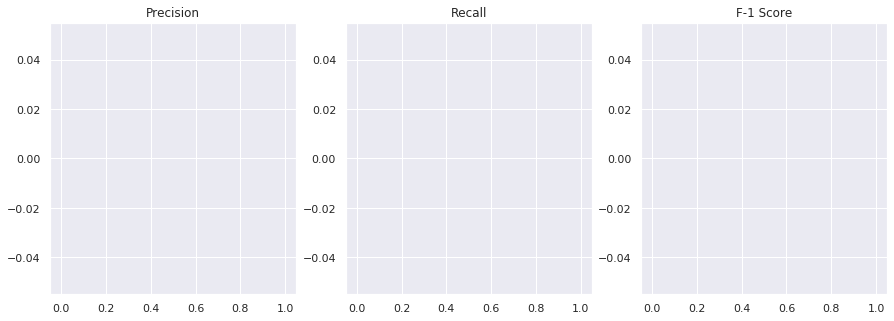

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].set_title('Precision')
axes[0].hist(precisions)
axes[1].set_title('Recall')
axes[1].hist(recalls)
axes[2].set_title('F-1 Score')
_=axes[2].hist(f1_scores)

In [19]:
accuracies = [[] for i in range(10)]
for i, h in enumerate(histories):
    for e in h['accuracy']:
        accuracies[i].append(h['accuracy'][e])

NameError: name 'histories' is not defined

In [20]:
accuracies = np.array(accuracies)
mean_accuracies = accuracies.mean(axis=0)
std_accuracies = accuracies.std(axis=0)

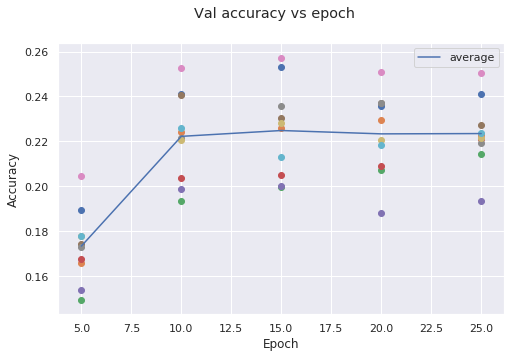

In [117]:
x = np.arange(5, 26, 5)
fig = plt.figure(figsize=(8, 5))
plt.suptitle('Val accuracy vs epoch')
plt.plot(x, mean_accuracies, label='average')
for i in range(10):
    plt.scatter(x, accuracies[i])
plt.xlabel('Epoch')
plt.legend()
_=plt.ylabel('Accuracy')

In [119]:
results = {}
results['mean_accuracies'] = mean_accuracies
results['std_accuracies'] = std_accuracies
results['epochs'] = np.arange(5, 26, 5)

In [123]:
with open(os.path.join(DUMP_DIR, 'baseline_10epochs_results.pkl'),'wb') as f:
    pickle.dump(results, f)

In [ ]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(512 * 512 * 6, 512),
            nn.ReLU(True),
            nn.Linear(256, 64),
            nn.ReLU(True))
        self.decoder = nn.Sequential(
            nn.Linear(64, 512),
            nn.ReLU(True),
            nn.Linear(512, 512 * 512 * 6),
            nn.Sigmoid())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
for epoch in range(NUM_EPOCHS):
    for data in train_loader:
        img, _ = data
        img = img.view(img.size(0), -1)
        img = Variable(img).cuda()
        # ===================forward=====================
        output = model(noisy_img)
        loss = criterion(output, img)
        MSE_loss = nn.MSELoss()(output, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}, MSE_loss:{:.4f}'
          .format(epoch + 1, num_epochs, loss.data[0], MSE_loss.data[0]))